In [21]:
!pip install softposit
# !pip install softfloat

In [22]:
# import softfloat as sf
import softposit as sp
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
p8=sp.posit8(5)
print("Posit8:", p8)
p8.toBinaryFormatted()

Posit8: 5.0
01110010


In [24]:
print('Using Integers:')
p8.fromBits(6)
p8.toBinaryFormatted()

Using Integers:
00000110


In [25]:
print("p8 type:", p8.type(), "\n")

p8 type: posit8 



In [26]:
#Sign Bit
print("For a value of", p8, ":")
p8.toBinaryFormatted()

print("\nFor a value of", -p8, ":")
(-p8).toBinaryFormatted()

For a value of 0.09375 :
00000110

For a value of -0.09375 :
11111010


In [27]:
#Regime
print("posit8: 0.00390625")
p8 = sp.posit8(0.00390625);
p8.toBinaryFormatted()
print("Six 0-bit terminated by a 1-bit. This implies regime runlength is 7.\n")

print("posit8: -0.00390625")
p8 = sp.posit16(-0.00390625);
p8.toBinaryFormatted()
print("Five 1-bit terminated by a 0-bit. This implies regime runlength is 5.\n")

print("posit8: 268435456")
p8 = sp.posit8(268435456) #maxpos
p8.toBinaryFormatted()
print("Seven 1-bit without a terminating bit, exponent bit and fraction bits. Regime runlength is 7 (ps-1).")

posit8: 0.00390625
00000001
Six 0-bit terminated by a 1-bit. This implies regime runlength is 7.

posit8: -0.00390625
11111100 00000000
Five 1-bit terminated by a 0-bit. This implies regime runlength is 5.

posit8: 268435456
01111111
Seven 1-bit without a terminating bit, exponent bit and fraction bits. Regime runlength is 7 (ps-1).


In [28]:
#Exponent
print("posit8: 2.76837158203125e0")
p8 = sp.posit8(4.76e-1)
p8.toBinaryFormatted()

print("\nShift bit to the right 3 times:");
p8>>=3
p8.toBinaryFormatted()
print("Exponent bit is being pushed out.");
print("posit8: ", p8)

posit8: 2.76837158203125e0
00011110

Shift bit to the right 3 times:
00000011
Exponent bit is being pushed out.
posit8:  0.046875


In [29]:
p8.fromBits(0x3F)
print("Posit8:", p8)
p8.toBinaryFormatted()

p8.fromBits(0x1)
print("\nPosit8:", p8)
p8.toBinaryFormatted()



Posit8: 0.984375
00111111

Posit8: 0.015625
00000001


In [30]:
print("\nPosit: Positive zero:")
p8 = sp.posit8(+0.0)
p8.toBinaryFormatted()

print("\nPosit: Negative zero:")
p8 = sp.posit8(-0.0)
p8.toBinaryFormatted()


Posit: Positive zero:
00000000

Posit: Negative zero:
00000000


In [31]:
p8.toNaR()

NaR

In [32]:
#Posit
p8  = p8.toNaR()
print("Posit: NaR")
p8.toNaR()
p8.toBinaryFormatted()
print(p8)

print("\nPosit: Divide by zero")
p8=sp.posit8(1)
p8/=0
p8.toBinaryFormatted()
print(p8)

print("\nPosit: Square root(negative number)")
p8=sp.posit8(-1)
p8 = p8.sqrt()
p8.toBinaryFormatted()
print(p8)

Posit: NaR
10000000
NaR

Posit: Divide by zero
10000000
NaR

Posit: Square root(negative number)
10000000
NaR


In [33]:
p8 = sp.posit8(0.3)
p8.toBinaryFormatted()
print("Actual p8 value: ", p8)

es = 1
sign = 0
useed = pow(2, pow(2, es))
e = 0
k = -1
f = int("001100110011", 2)
p = pow((-1), sign) * pow(useed, k) * pow(2, e) * (1 + (f / (int("111111111111", 2))))
print("Rounded p value:", p)
print("P value to 14 decimal points: {0:.14f}".format(round(p,2)))
print("P value to 14 decimal points: {0:.20f}".format(round(p,2)))

00010011
Actual p8 value:  0.296875
Rounded p value: 0.3
P value to 14 decimal points: 0.30000000000000
P value to 14 decimal points: 0.29999999999999998890


In [34]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [35]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [36]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [37]:
example_data.shape

torch.Size([1000, 1, 28, 28])

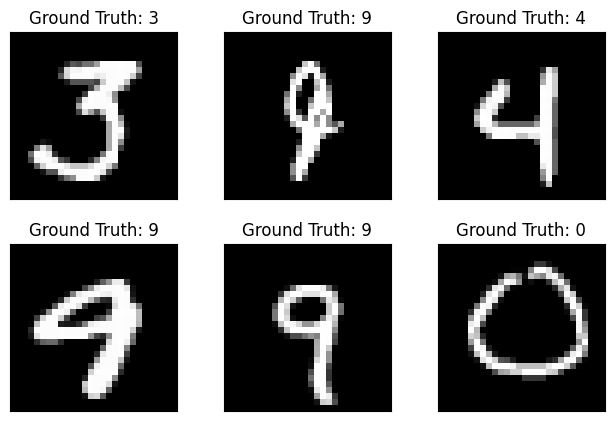

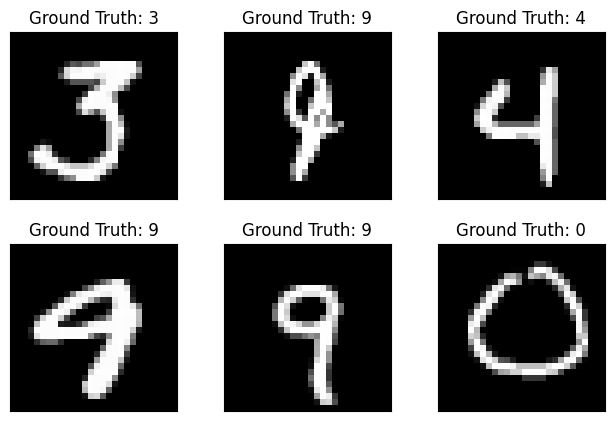

In [38]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [40]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [41]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [42]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [43]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [44]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-39-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179


RuntimeError: ignored